# Phase 2: Baseline Evaluation — MURA-Finance

**Scope**: Evaluate **only** the Original_Paper baselines (FinBERT + single-shot GPT). No 5-hop or RAG.

## Objectives
1. **Metrics**: Accuracy, precision, recall, F1 (macro/micro), confusion matrices
2. **Model comparison**: FinBERT vs GPT, standard vs _n, single-article vs daily (p5, p6)
3. **Error analysis**: Failure cases, patterns
4. **Performance**: Token usage, timing, cost estimates
5. **Statistical tests**: McNemar, bootstrap CI
6. **Best model recommendations**

## 1. Setup and load report

In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, str(Path().resolve().parent))

from src.utils.data_loader import load_all_dataframes
from src.evaluation.comparison import build_model_comparison_report

base = Path().resolve().parent
data = load_all_dataframes(base)
sa = data["single_article"]
ad = data.get("allday_articles")

report = build_model_comparison_report(base)
print("Report keys:", list(report.keys()))
single = report["single_article_evaluation"]
allday = report["allday_evaluation"]
perf = report["performance"]
err = report["error_analysis"]

Loaded ground truth: 2291 rows
Loaded single article predictions: 2291 rows
Loaded all-day articles: 293 rows


## 2. Metrics tables

In [25]:
rows = []
for name, v in single.items():
    if "error" in v:
        rows.append({"model": name, "accuracy": None, "f1_macro": None, "precision_macro": None, "recall_macro": None})
        continue
    m = v["metrics"]
    rows.append({
        "model": name,
        "accuracy": m["accuracy"],
        "f1_macro": m["f1_macro"],
        "precision_macro": m["precision_macro"],
        "recall_macro": m["recall_macro"],
    })
df_met = pd.DataFrame(rows)
display(df_met)

,model,accuracy,f1_macro,precision_macro,recall_macro
0,finbert,0.470973,0.458897,0.513871,0.463947
1,finbert_a,0.439546,0.404787,0.456715,0.454654
2,gpt_p1,0.730249,0.728084,0.762620,0.733715
3,gpt_p2,0.790048,0.792450,0.799357,0.792704
4,gpt_p3,0.735487,0.738709,0.786017,0.732212
5,gpt_p4,0.784374,0.789522,0.808617,0.782728
6,gpt_p7,0.589262,0.587215,0.694598,0.582559
7,gpt_p1n,0.651244,0.589593,0.707367,0.669067
8,gpt_p2n,0.655172,0.607072,0.719739,0.671280
9,gpt_p3n,0.719337,0.709447,0.733980,0.729224


## 3. Confusion matrices (heatmaps)

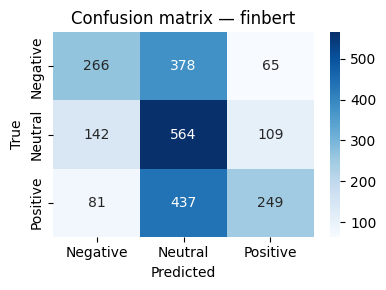

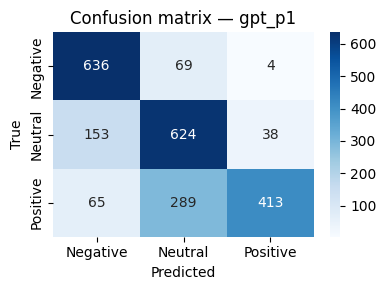

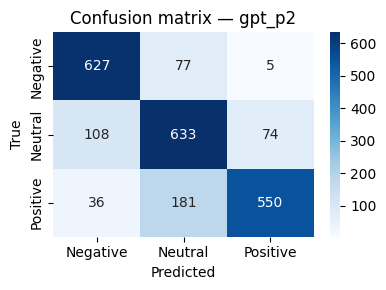

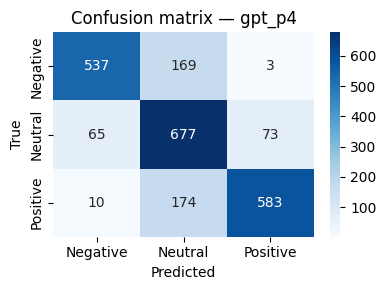

In [26]:
labels = ["Negative", "Neutral", "Positive"]
for name in ["finbert", "gpt_p1", "gpt_p2", "gpt_p4"]:
    if name not in single or "confusion_matrix" not in single[name]:
        continue
    cm = single[name]["confusion_matrix"]
    M = np.array(cm["matrix"])
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(M, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion matrix — {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()
    plt.show()

## 4. Performance (tokens, time, cost)

,prompt_tokens_total,completion_tokens_total,total_time_sec,estimated_cost_usd
gpt_p1,142422.0,2291.0,2147.783063,0.2182
gpt_p2,151547.0,2291.0,1859.542771,0.2319
gpt_p3,148702.0,2291.0,2231.250844,0.2276
gpt_p4,191048.0,2291.0,1867.363135,0.2912
gpt_p7,997370.0,3999.0,1501.820107,1.5041
gpt_p1n,172205.0,34756.0,5243.465877,0.3278
gpt_p2n,174477.0,19786.0,3245.001603,0.3013
gpt_p3n,173762.0,9466.0,2829.369053,0.2796
gpt_p4n,200071.0,7981.0,2438.712023,0.3161
gpt_p7n,1122731.0,9237.0,1624.603196,1.7026


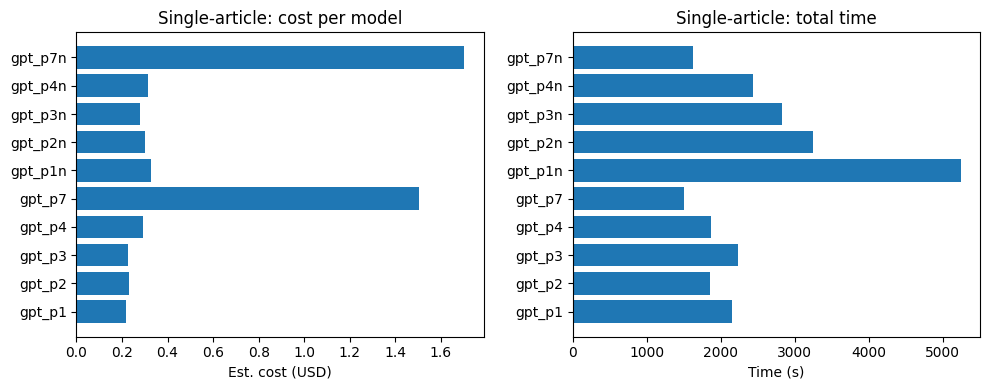

In [27]:
pf = pd.DataFrame(perf["single_article"]).T
display(pf)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.barh(list(perf["single_article"].keys()), [p["estimated_cost_usd"] for p in perf["single_article"].values()])
ax.set_xlabel("Est. cost (USD)")
ax.set_title("Single-article: cost per model")
ax = axes[1]
ax.barh(list(perf["single_article"].keys()), [p["total_time_sec"] for p in perf["single_article"].values()])
ax.set_xlabel("Time (s)")
ax.set_title("Single-article: total time")
plt.tight_layout()
plt.show()

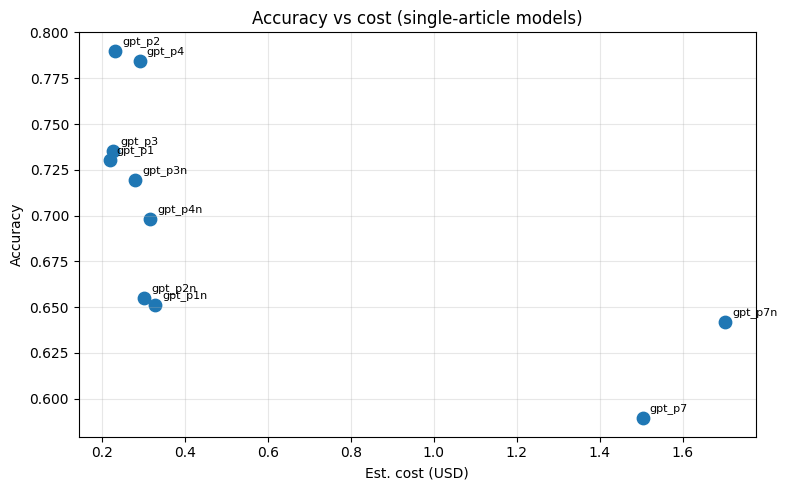

In [28]:
# Accuracy vs efficiency trade-off (single-article)
names, acc, cost = [], [], []
for n in perf["single_article"]:
    if n not in single or "metrics" not in single[n]:
        continue
    names.append(n)
    acc.append(single[n]["metrics"]["accuracy"])
    cost.append(perf["single_article"][n]["estimated_cost_usd"])
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(cost, acc, s=80)
for i, n in enumerate(names):
    ax.annotate(n, (cost[i], acc[i]), xytext=(5, 5), textcoords="offset points", fontsize=8)
ax.set_xlabel("Est. cost (USD)")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs cost (single-article models)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Error analysis — sample failure cases

In [29]:
idx = err["sample_commonly_failed_indices"][:5]
cols = ["title", "true_sentiment", "finbert_sentiment", "gpt_sentiment_p1", "gpt_sentiment_p2", "gpt_sentiment_p4"]
available = [c for c in cols if c in sa.columns]
sample = sa.iloc[idx][available]
display(sample)

,title,true_sentiment,finbert_sentiment,gpt_sentiment_p1,gpt_sentiment_p2,gpt_sentiment_p4
1,EURCHF Trend higher may remain in place – ING,1,0,1,1,1
2,Does a jump in EURCHF point to a break above 1...,0,0,0,1,0
3,EURCHF could extend its advance back to levels...,1,0,0,1,1
4,EURCHF to head higher towards 10130 and projec...,1,0,1,1,1
5,EURCHF Room for the Euro to extend the move hi...,1,0,1,1,1


## 6. Statistical tests and recommendations

In [30]:
tests = report.get("statistical_tests", {})
for pair, res in tests.get("mcnemar", {}).items():
    print(f"{pair}: p = {res.get('p_value', 'N/A'):.4f} — {res.get('interpretation', '')}")

best = max(
    [(n, v["metrics"]["f1_macro"]) for n, v in single.items() if "metrics" in v],
    key=lambda x: x[1],
)
print(f"\nBest single-article (F1 macro): {best[0]} (F1 = {best[1]:.4f})")

finbert_vs_gpt_p1: p = 0.0000 — A vs B differ significantly (p < 0.05)
gpt_p1_vs_gpt_p7: p = 0.0000 — A vs B differ significantly (p < 0.05)
finbert_a_vs_gpt_p1n: p = 0.0000 — A vs B differ significantly (p < 0.05)

Best single-article (F1 macro): gpt_p2 (F1 = 0.7924)
